**<h1>Identifying Inappropriate Table of Surgical Procedures (TOSP) Pair Codes with Agglomerative and Spectral Clustering</h1>**

In [1]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Loading the data (combined_dataset.csv)
df_tosp = pd.read_csv("combined_dataset.csv")

# Extract descriptions and vectorize them using TF‑IDF
descriptions = df_tosp["Description"].tolist()
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(descriptions)

Linkage: average, n_clusters: 100, silhouette score: 0.1063
Linkage: average, n_clusters: 300, silhouette score: 0.1911
Linkage: average, n_clusters: 500, silhouette score: 0.2624
Linkage: average, n_clusters: 700, silhouette score: 0.3085
Linkage: average, n_clusters: 900, silhouette score: 0.3358
Linkage: average, n_clusters: 1100, silhouette score: 0.3471
Linkage: average, n_clusters: 1300, silhouette score: 0.3601
Linkage: average, n_clusters: 1500, silhouette score: 0.3448
Linkage: average, n_clusters: 1700, silhouette score: 0.3123
Linkage: average, n_clusters: 1900, silhouette score: 0.2543
Linkage: average, n_clusters: 2100, silhouette score: 0.1698
Linkage: complete, n_clusters: 100, silhouette score: 0.0087
Linkage: complete, n_clusters: 300, silhouette score: 0.1768
Linkage: complete, n_clusters: 500, silhouette score: 0.2619
Linkage: complete, n_clusters: 700, silhouette score: 0.3133
Linkage: complete, n_clusters: 900, silhouette score: 0.3482
Linkage: complete, n_clusters

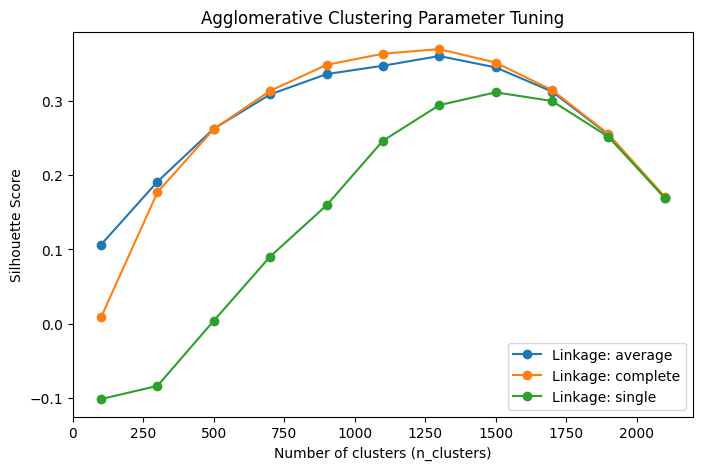

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Assume X is your TF‑IDF matrix (e.g., from TOSP code descriptions)
# If X is a sparse matrix, convert to array when needed (or work directly with the sparse format if possible).

# Define the range of n_clusters and the linkage methods to test
linkage_methods = ['average', 'complete', 'single']  # 'ward' is not used with cosine affinity
n_clusters_range = range(100, 2300, 200)  # Example range; adjust based on your dataset size

results = []

for linkage in linkage_methods:
    for n_clusters in n_clusters_range:
        agg = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage=linkage)
        labels = agg.fit_predict(X.toarray())
        # Compute silhouette score using cosine distance
        score = silhouette_score(X, labels, metric='cosine')
        results.append((linkage, n_clusters, score))
        print(f"Linkage: {linkage}, n_clusters: {n_clusters}, silhouette score: {score:.4f}")

# Convert results to a DataFrame for easier plotting and analysis
df_results = pd.DataFrame(results, columns=["linkage", "n_clusters", "silhouette"])

# Plot the silhouette scores for different parameter combinations
plt.figure(figsize=(8, 5))
for linkage in linkage_methods:
    subset = df_results[df_results["linkage"] == linkage]
    plt.plot(subset["n_clusters"], subset["silhouette"], marker='o', label=f'Linkage: {linkage}')
plt.xlabel("Number of clusters (n_clusters)")
plt.ylabel("Silhouette Score")
plt.title("Agglomerative Clustering Parameter Tuning")
plt.legend()
plt.show()

n_clusters: 500, silhouette score: 0.0810
n_clusters: 600, silhouette score: 0.0999
n_clusters: 700, silhouette score: 0.1412
n_clusters: 800, silhouette score: 0.1775
n_clusters: 900, silhouette score: 0.1974


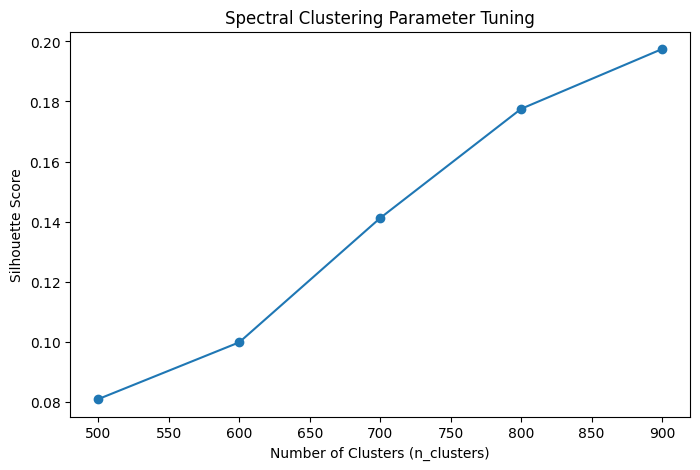

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Assume X is your TF‑IDF matrix from the TOSP code descriptions.
# Compute the cosine similarity matrix.
similarity_matrix = cosine_similarity(X)

# Define a range for the number of clusters to test.
n_clusters_range = range(500, 1000, 100)

spectral_results = []

for n_clusters in n_clusters_range:
    # Use spectral clustering with the precomputed cosine similarity matrix.
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(similarity_matrix)

    # Compute the silhouette score on the original TF‑IDF vectors using cosine distance.
    score = silhouette_score(X, labels, metric='cosine')
    spectral_results.append((n_clusters, score))
    print(f"n_clusters: {n_clusters}, silhouette score: {score:.4f}")

# Convert the results into a format suitable for plotting.
import pandas as pd
df_spectral = pd.DataFrame(spectral_results, columns=['n_clusters', 'silhouette'])

plt.figure(figsize=(8, 5))
plt.plot(df_spectral['n_clusters'], df_spectral['silhouette'], marker='o')
plt.xlabel("Number of Clusters (n_clusters)")
plt.ylabel("Silhouette Score")
plt.title("Spectral Clustering Parameter Tuning")
plt.show()



In [5]:
# Training Agglomerative Clustering.
n_clusters = 1300  # Based on silhouette score)
agg = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
agg_labels = agg.fit_predict(X.toarray())

# Training Spectral Clustering.
s_clusters = 850
spectral = SpectralClustering(n_clusters=s_clusters, affinity='cosine', random_state=42)
spectral_labels = spectral.fit_predict(X)

# Assign cluster labels to the dataframe.
df_tosp["Agglomerative_Label"] = agg_labels
df_tosp["Spectral_Label"] = spectral_labels

# Defining a function to test a pair of codes.
def test_code_pair(code1, code2, df, vectorizer):
    # Locate the indices of the provided codes
    idx1_list = df.index[df["Code"] == code1].tolist()
    idx2_list = df.index[df["Code"] == code2].tolist()

    if not idx1_list or not idx2_list:
        print(f"One or both codes ({code1}, {code2}) were not found.")
        return

    idx1 = idx1_list[0]
    idx2 = idx2_list[0]

    # Retrieve the TOSP code descriptions
    desc1 = df.loc[idx1, "Description"]
    desc2 = df.loc[idx2, "Description"]

    # Get cluster labels from both KMeans and DBSCAN
    agg_label1 = df.loc[idx1, "Agglomerative_Label"]
    agg_label2 = df.loc[idx2, "Agglomerative_Label"]
    spectral_label1 = df.loc[idx1, "Spectral_Label"]
    spectral_label2 = df.loc[idx2, "Spectral_Label"]

    same_agg = (agg_label1 == agg_label2)
    same_spectral = (spectral_label1 == spectral_label2)

    # Compute cosine similarity using TF‑IDF vectors
    vec1 = vectorizer.transform([desc1])
    vec2 = vectorizer.transform([desc2])
    cos_sim = cosine_similarity(vec1, vec2)[0][0]

    # Output the results
    print(f"Comparing code pair: {code1} vs {code2}")
    print(f"Agglomerative -> {code1} in cluster {agg_label1}, {code2} in cluster {agg_label2}. Same cluster: {same_agg}")
    print(f"Spectral  -> {code1} in cluster {spectral_label1}, {code2} in cluster {spectral_label2}. Same cluster: {same_spectral}")
    print(f"Cosine similarity (TF‑IDF): {cos_sim:.4f}")

# Test the function with a specific pair of codes
# In example #1 below, we will compare codes "SL701L" and "SL702L"
# As you can see, since both are similar in description, the cosine similarity is high, both KMeans and DBSCAN is clustering them together
test_code_pair("SL701L", "SL702L", df_tosp, vectorizer)

print()

# In example #2 below, we will compare codes "SL702L" and "SL705O"
# KMeans is clustered correctly (both are vastly different opterations) but DBSCAN is incorrectly clustering them together as noise
# The cosine similarity seems to be correct also
test_code_pair("SL701L", "SL705O", df_tosp, vectorizer)

Comparing code pair: SL701L vs SL702L
Agglomerative -> SL701L in cluster 99, SL702L in cluster 99. Same cluster: True
Spectral  -> SL701L in cluster 231, SL702L in cluster 231. Same cluster: True
Cosine similarity (TF‑IDF): 0.9611

Comparing code pair: SL701L vs SL705O
Agglomerative -> SL701L in cluster 99, SL705O in cluster 893. Same cluster: False
Spectral  -> SL701L in cluster 231, SL705O in cluster 729. Same cluster: False
Cosine similarity (TF‑IDF): 0.0000


In [6]:
import joblib

# Save Agg Model
joblib.dump(agg, "Agg_Model.pkl")

# Save Spectral Model
joblib.dump(spectral, "Spectral_Model.pkl")

['Spectral_Model.pkl']